In [1]:
# import libraries numpy and pandas

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../Dataset/" directory.

import os
print(os.listdir("./Dataset"))


['models', 'cell_images-total.zip', 'tuberculosis-phonecamera.zip', 'logs', 'images-without-bbbc', 'MP-IDB-The-Malaria-Parasite-Image-Database-for-Image-Processing-and-Analysis', 'intestinalparasites-phonecamera.zip', 'patientid_cellmapping_uninfected.csv', 'malaria-bbbc', 'malaria-vivax', 'plasmodium-phonecamera.zip', 'tuberculosis-phonecamera', 'malaria-plasmodium', 'plasmodium-phonecamera', 'patientid_cellmapping_parasitized.csv', 'cell_images-old', '2018_SaMBa_MP-IDB.pdf', 'cell_images', 'Unconfirmed 806475.crdownload', 'Awesome_Malaria_Parasite_Imaging_Datasets-master.zip', 'output', 'intestinalparasites-phonecamera', 'cell-images-for-detecting-malaria', 'malaria_cell_classification_code.zip', 'malaria (1).zip', 'cell-images-for-detecting-malaria.zip', 'malaria_cell_classification_code', 'resizedCellsImagesMalaria', 'results', 'malaria.zip', 'cell_images.zip', 'plasmodium-phonecamera (1).zip', 'plasmodium-images', 'plasmodium-phonecamera (1)']


In [2]:
#import other libraries
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL.Image
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import np_utils
import time

from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Dropout,Dense,Flatten,BatchNormalization,Conv2D
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras import  optimizers
from keras import backend as K

Using TensorFlow backend.
/home/uzairhussain/my_project_dir/my_project_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/uzairhussain/my_project_dir/my_project_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/uzairhussain/my_project_dir/my_project_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qi

In [3]:
#assign parasitezed images to infected and uninfected images to uninfected
infected = os.listdir('./Dataset/cell_images/Parasitized/')
uninfected = os.listdir('./Dataset/cell_images/Uninfected/')

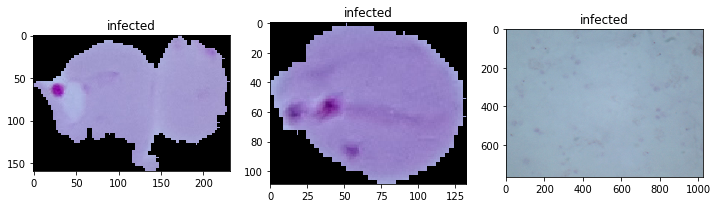

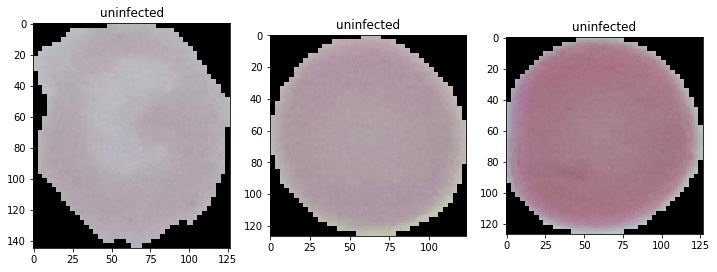

In [4]:
#then plot the figures of images
plt.figure(figsize=(12,12))
for i in range(3):
    plt.subplot(1,3,i+1)
    img = cv2.imread('./Dataset/cell_images/Parasitized/'+infected[i])
    plt.imshow(img)
    plt.title('infected')
plt.figure(figsize=(12,12))
for i in range(3):
    plt.subplot(1,3,i+1)
    img2 = cv2.imread('./Dataset/cell_images/Uninfected/'+uninfected[i])
    plt.imshow(img2)
    plt.title('uninfected')

In [5]:
def Convert_Image_to_Array(input_path_infected, input_path_uninfected):
    data = []
    labels = []

    for i in infected:
        try:
            image = cv2.imread(input_path_infected+i)
            image_resized = cv2.resize(image,(64,64))
            image_array = img_to_array(image_resized)
            data.append(image_array)
            labels.append(1)
        except:
            print('error while reading :',i)

    for i in uninfected:
        try:
            image = cv2.imread(input_path_uninfected+i)
            image_resized = cv2.resize(image,(64,64))
            image_array = img_to_array(image_resized)
            data.append(image_array)
            labels.append(0)
        except:
            print('error while reading :',i) 
    
    data_array = np.array(data)
    labels_array = np.array(labels)
    
    idx = np.arange(data_array.shape[0]) #get all the indices of data and labels
    np.random.shuffle(idx) #randomly shuffle
    image_data = data_array[idx] #get shuffled indices data
    labels = labels_array[idx] #get shuffled labels
    image_data = image_data/255
    return image_data, labels


In [6]:
def Generate_train_val_test_Data(image_data, labels, num_of_classes):
    X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size = 0.15, random_state = 42)
    X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size = 0.17, random_state = 42)
    y_train = np_utils.to_categorical(y_train, num_classes = num_of_classes)
    y_val = np_utils.to_categorical(y_val, num_classes = num_of_classes)
    y_test = np_utils.to_categorical(y_test, num_classes = num_of_classes)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
# More Data Generating With same image i.e. data augmnetation

def generate_data_aug(X_train, y_train):
    datagen = ImageDataGenerator(rotation_range=10, zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1)  
    datagen.fit(X_train)
    data_from_generator = datagen.flow(X_train,y_train, batch_size = 86)
    return data_from_generator

In [8]:
#for callbacks
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [9]:
# Define CNN Model
def Create_Model_CNN(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)


    model.add(Conv2D(16, (3,3),padding='same', activation = 'relu', input_shape = inputShape))
    model.add(Conv2D(16, (3,3),padding='same', activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(32, (3,3),padding='same', activation = 'relu', input_shape = inputShape))
    model.add(Conv2D(32, (3,3),padding='same', activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(64, (3,3),padding='same', activation = 'relu'))
    model.add(Conv2D(64, (3,3),padding='same', activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    
    
    model.add(Conv2D(128, (3,3),padding='same', activation = 'relu'))
    model.add(Conv2D(128, (3,3),padding='same', activation = 'relu'))
    model.add(MaxPooling2D(2,2))


    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

In [11]:
def compile_build_fit_model(model, optmizer_param, metric_param, loss_param, data_from_generator, X_val, y_val, callbackParameter):
    model.compile(optimizer = optmizer_param , loss = loss_param, metrics = [metric_param])
    model_history = model.fit_generator(data_from_generator,epochs = 30, validation_data = (X_val,y_val),verbose = 1, steps_per_epoch = X_train.shape[0] // 86, callbacks=[callbackParameter])
    return model_history

In [12]:
# testing,training and validation dataset generating
image_data, labels = Convert_Image_to_Array('./Dataset/cell_images/Parasitized/','./Dataset/cell_images/Uninfected/')
X_train,X_val, X_test, y_train, y_val, y_test = Generate_train_val_test_Data(image_data, labels, num_of_classes = 2)
print('X_train shape: ', X_train.shape)
print('X_val shape: ', X_val.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_val shape: ', y_val.shape)
print('y_test shape: ', y_test.shape)

error while reading : Thumbs.db
error while reading : Thumbs.db
X_train shape:  (24427, 64, 64, 3)
X_val shape:  (5004, 64, 64, 3)
X_test shape:  (5194, 64, 64, 3)
y_train shape:  (24427, 2)
y_val shape:  (5004, 2)
y_test shape:  (5194, 2)


In [13]:
data_from_generator = generate_data_aug(X_train, y_train)


In [14]:
# CNN model training
cnn_model = Create_Model_CNN(height=64, width=64, channels=3, classes=2)
cnn_model_history = compile_build_fit_model(cnn_model, 
                                        optmizer_param='adam', 
                                        metric_param='accuracy', 
                                        loss_param='categorical_crossentropy', 
                                        data_from_generator = data_from_generator, 
                                        X_val = X_val,
                                        y_val = y_val, 
                                        callbackParameter=learning_rate_reduction)


print('Fitting the model on data completed.\n training accuracy : {} \n Training loss : {}'.format(cnn_model_history.history['accuracy'][-1],cnn_model_history.history['loss'][-1]))



Epoch 1/30
284/284 [==============================] - 185s 650ms/step - loss: 0.4297 - accuracy: 0.7768 - val_loss: 0.1616 - val_accuracy: 0.9500


/home/uzairhussain/my_project_dir/my_project_env/lib/python3.6/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/30
284/284 [==============================] - 189s 664ms/step - loss: 0.1477 - accuracy: 0.9520 - val_loss: 0.1506 - val_accuracy: 0.9536
Epoch 3/30
284/284 [==============================] - 196s 689ms/step - loss: 0.1351 - accuracy: 0.9569 - val_loss: 0.1059 - val_accuracy: 0.9654
Epoch 4/30
284/284 [==============================] - 204s 718ms/step - loss: 0.1153 - accuracy: 0.9625 - val_loss: 0.1075 - val_accuracy: 0.9690
Epoch 5/30
284/284 [==============================] - 204s 718ms/step - loss: 0.1115 - accuracy: 0.9632 - val_loss: 0.1023 - val_accuracy: 0.9688
Epoch 6/30
284/284 [==============================] - 204s 720ms/step - loss: 0.1115 - accuracy: 0.9635 - val_loss: 0.1026 - val_accuracy: 0.9670
Epoch 7/30
284/284 [==============================] - 204s 718ms/step - loss: 0.1034 - accuracy: 0.9648 - val_loss: 0.0993 - val_accuracy: 0.9690
Epoch 8/30
284/284 [==============================] - 205s 721ms/step - loss: 0.1020 - accuracy: 0.9661 - val_loss: 0.0992 -

In [16]:
#Evaluate Test results
cnn_testresults = cnn_model.evaluate(X_test, y_test)

print('Test results are as below \n Test accuracy : {} \n Test loss : {}'.format(cnn_testresults[1],cnn_testresults[0]))

5194/5194 [==============================] - 9s 2ms/step
Test results are as below 
 Test accuracy : 0.9742010235786438 
 Test loss : 0.07456951441647092


In [17]:
# training and validation accuracy
# training and validation loss
accuracy = cnn_model_history.history['accuracy']
loss = cnn_model_history.history['loss']
val_accuracy = cnn_model_history.history['val_accuracy']
val_loss = cnn_model_history.history['val_loss']

print(f'Training Accuracy: {np.max(accuracy)}')
print(f'Training Loss: {np.min(loss)}')
print(f'Validation Accuracy: {np.max(val_accuracy)}')
print(f'Validation Loss: {np.min(val_loss)}')

Training Accuracy: 0.9756789207458496
Training Loss: 0.07031029688592667
Validation Accuracy: 0.974020779132843
Validation Loss: 0.08422608016621616


In [18]:
# model summary
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)       

In [20]:
# Precision, recall and f-score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = cnn_model.predict(image_data)
y_pred = np.argmax(y_pred1, axis=1)

# Print f1, precision, and recall scores
print(f'Precision Score:')

print(precision_score(labels, y_pred , average="macro"))
print(f'Recall Score:')

print(recall_score(labels, y_pred , average="macro"))
print(f'F1 Score:')
print(f1_score(labels, y_pred , average="macro"))

Precision Score:
0.9795543033001681
Recall Score:
0.9800298493044128
F1 Score:
0.9797816470908758


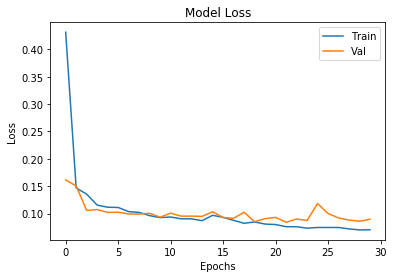

In [21]:
# plot the graph
# training and validation loss
plt.plot(cnn_model_history.history["loss"])
plt.plot(cnn_model_history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

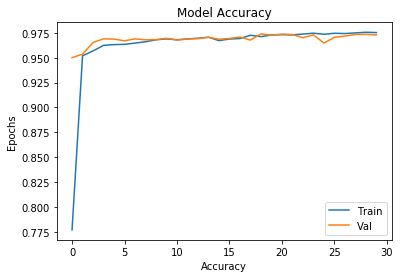

In [22]:
# plot the graph 
# training and validation accuracy
plt.plot(cnn_model_history.history['accuracy'])
plt.plot(cnn_model_history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [26]:
# confusion matrix predictions
rounded_predictions = cnn_model.predict_classes(X_test, batch_size=86, verbose=0)
rounded_predictions[1]
# 2

1

In [27]:
import numpy as np
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
# 2

1

In [36]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, rounded_predictions)
cm

array([[2375,   63],
       [  71, 2685]])

In [46]:
# define confusion matrix
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

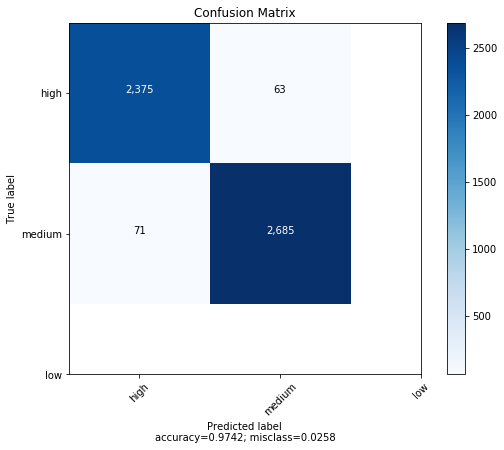

In [47]:
# draw confusion matrix
plot_confusion_matrix(cm           = np.array([[ 2375,   63],
                                              [  71, 2685],
                                              ]), 
                      normalize    = False,
                      target_names = ['high', 'medium', 'low'],
                      title        = "Confusion Matrix")

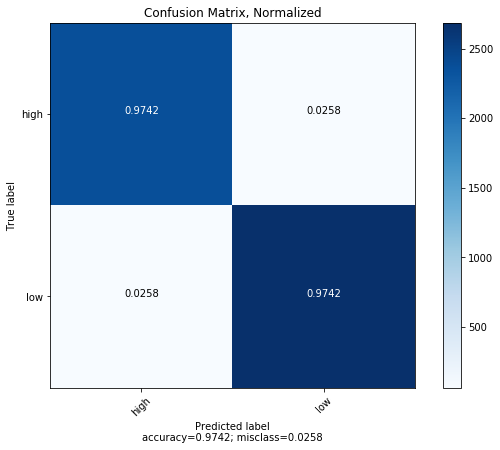

In [50]:
plot_confusion_matrix(cm           = np.array([[ 2375,   63],
                                              [  71, 2685],
                                              ]), 
                      normalize    = True,
                      target_names = ['high',  'low'],
                      title        = "Confusion Matrix, Normalized")

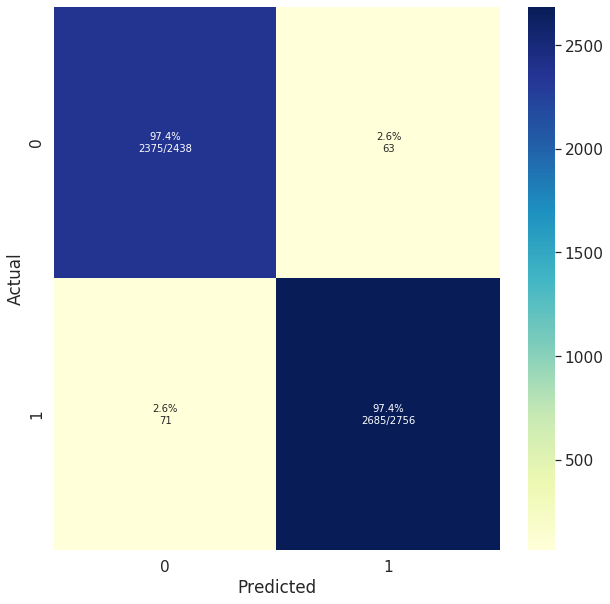

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(rounded_labels, rounded_predictions, figsize=(10,10)):
    cm = confusion_matrix(rounded_labels, rounded_predictions, labels=np.unique(rounded_labels))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(rounded_labels), columns=np.unique(rounded_labels))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
plot_cm(rounded_labels, rounded_predictions)

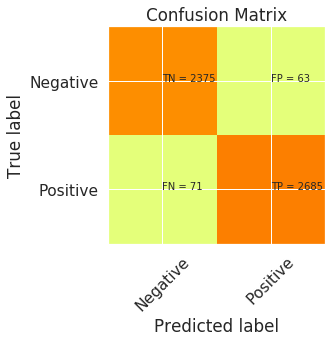

In [61]:
# true and prediction label
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

Text(0.5, 257.44, 'Predicted label')

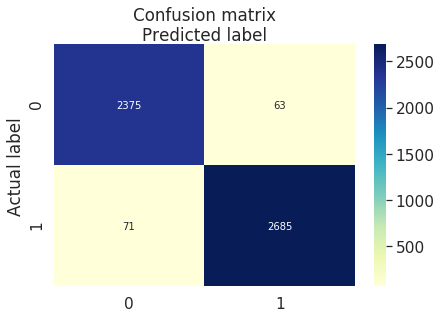

In [98]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [99]:
print("Accuracy:",metrics.accuracy_score(rounded_labels, rounded_predictions))
print("Precision:",metrics.precision_score(rounded_labels, rounded_predictions))
print("Recall:",metrics.recall_score(rounded_labels, rounded_predictions))

Accuracy: 0.974201001155179
Precision: 0.9770742358078602
Recall: 0.9742380261248186


In [103]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(rounded_labels, rounded_predictions)
cnf_matrix

array([[2375,   63],
       [  71, 2685]])

In [112]:
def calculate_sensitivity_specificity(rounded_labels, rounded_predictions):
    # Note: More parameters are defined than necessary. 
    # This would allow return of other measures other than sensitivity and specificity
    
    # Get true/false for whether a breach actually occurred
    actual_pos = rounded_labels == 1
    actual_neg = rounded_labels == 0
    
    # Get true and false test (true test match actual, false tests differ from actual)
    true_pos = (rounded_predictions == 1) & (actual_pos)
    false_pos = (rounded_predictions == 1) & (actual_neg)
    true_neg = (rounded_predictions == 0) & (actual_neg)
    false_neg = (rounded_predictions == 0) & (actual_pos)
    
    # Calculate accuracy
    accuracy = np.mean(rounded_predictions == rounded_labels)
    
    # Calculate sensitivity and specificity
    sensitivity = np.sum(true_pos) / np.sum(actual_pos)
    specificity = np.sum(true_neg) / np.sum(actual_neg)
    
    return sensitivity, specificity, accuracy

In [113]:
sensitivity, specificity, accuracy = calculate_sensitivity_specificity(rounded_labels, rounded_predictions)
print ('Sensitivity:', sensitivity)
print ('Specificity:', specificity)
print ('Accuracy:', accuracy)

Sensitivity: 0.9742380261248186
Specificity: 0.9741591468416735
Accuracy: 0.974201001155179


In [116]:
cuttoff = np.arange (0.01,1.01,0.01)
sensitivity_results = []
specificity_results = []


for threshold in cuttoff:
    # linear regression model has .predict+proba  method to return 
    # probability of outcomes. Some methods such as svc use 
    # .decision_function to return probability
        
    # Get test results 
    
    # Check probability of positive classification is >trhreshold
   #y_pred_test = (rounded_predictions[:,1] >= threshold)
    
    # Convert boolean to 0/1 (could also simply multiple by 1)
    #y_pred_test = y_pred_test.astype(int)
    
    # Get sensitivity and specificity
    sensitivity, specificity, accuracy = \
        calculate_sensitivity_specificity(rounded_labels, rounded_predictions)
    
    # Add results to list of results
    sensitivity_results.append(sensitivity)
    specificity_results.append(specificity)  
    

In [130]:
import numpy as np
from sklearn.metrics import confusion_matrix

y_true = rounded_labels
y_prediction = rounded_predictions
cnf_matrix = confusion_matrix(y_true, y_prediction)
print(cnf_matrix)
#[[1 1 3]
# [3 2 2]
# [1 3 1]]

FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
print('False Positive rate:')
print(FP)
print('False Negative rate:')
print(FN)
print('True Positive rate:')
print(TP)
print('True Negative rate:')
print(TN)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('Sensitivity:')
print(TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('Specificity:')
print(TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('precision:')
print(PPV)
# Negative predictive value
NPV = TN/(TN+FN)
print('Negative Predictive:')
print(NPV)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('False positive:')
print(FPR)
# False negative rate
FNR = FN/(TP+FN)
print('False Negative:')
print(FNR)
# False discovery rate
FDR = FP/(TP+FP)
('False dicovery:')
print(FDR)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy:')
print(ACC)

[[2375   63]
 [  71 2685]]
False Positive rate:
[71. 63.]
False Negative rate:
[63. 71.]
True Positive rate:
[2375. 2685.]
True Negative rate:
[2685. 2375.]
Sensitivity:
[0.97415915 0.97423803]
Specificity:
[0.97423803 0.97415915]
precision:
[0.97097302 0.97707424]
Negative Predictive:
[0.97707424 0.97097302]
False positive:
[0.02576197 0.02584085]
False Negative:
[0.02584085 0.02576197]
[0.02902698 0.02292576]
Accuracy:
[0.974201 0.974201]


In [140]:
>>> from sklearn.metrics import matthews_corrcoef
>>> y_true = rounded_labels
>>> y_pred = rounded_predictions
print('Matthews Correlation Coefficient Score is:')
>>> matthews_corrcoef(y_true, y_pred)

Matthews Correlation Coefficient Score is:


0.9482221968313633

In [147]:
>>> import numpy as np
>>> from sklearn.metrics import roc_auc_score
>>> y_true = np.array(rounded_labels)
>>> y_scores = np.array(rounded_predictions)
print('Area Under The Curve')
>>> roc_auc_score(y_true, y_scores)

Area Under The Curve


0.974198586483246

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# roc curve and auc score
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
auc = roc_auc_score(rounded_labels, rounded_predictions)


In [162]:
fpr, tpr, thresholds = roc_curve(rounded_labels, rounded_predictions)


In [164]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

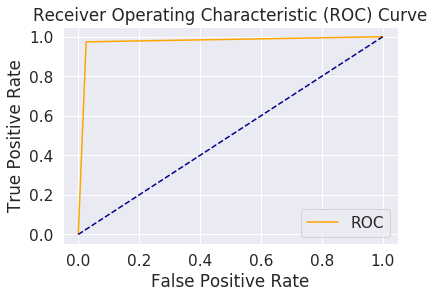

In [165]:
plot_roc_curve(fpr, tpr)
